In [1]:
# Run this ONCE (then you can comment it out)
# If TensorFlow install gives any error, restart the kernel after installation and run from Cell 2.

# !pip install yfinance pandas numpy scikit-learn tensorflow


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
start = "2012-01-01"
end   = "2024-12-31"

tickers = ["^NSEBANK", "^NSEI", "^INDIAVIX", "^GSPC"]

data = yf.download(tickers, start=start, end=end)

print("Downloaded columns:")
print(data.columns)

# Use CLOSE prices (Adj Close may not exist due to auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    close = data["Close"].copy()   # level 0 = 'Close', level 1 = ticker
else:
    close = data.filter(items=tickers)

close = close.dropna()
print("\nClose price sample:")
print(close.head())


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32152\4241137856.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  4 of 4 completed

Downloaded columns:
MultiIndex([( 'Close',     '^GSPC'),
            ( 'Close', '^INDIAVIX'),
            ( 'Close',  '^NSEBANK'),
            ( 'Close',     '^NSEI'),
            (  'High',     '^GSPC'),
            (  'High', '^INDIAVIX'),
            (  'High',  '^NSEBANK'),
            (  'High',     '^NSEI'),
            (   'Low',     '^GSPC'),
            (   'Low', '^INDIAVIX'),
            (   'Low',  '^NSEBANK'),
            (   'Low',     '^NSEI'),
            (  'Open',     '^GSPC'),
            (  'Open', '^INDIAVIX'),
            (  'Open',  '^NSEBANK'),
            (  'Open',     '^NSEI'),
            ('Volume',     '^GSPC'),
            ('Volume', '^INDIAVIX'),
            ('Volume',  '^NSEBANK'),
            ('Volume',     '^NSEI')],
           names=['Price', 'Ticker'])

Close price sample:
Ticker            ^GSPC  ^INDIAVIX     ^NSEBANK        ^NSEI
Date                                                        
2012-01-03  1277.060059  26.160000  8340.203125  4765.2998

In [4]:
# Main dataframe
df = pd.DataFrame(index=close.index)
df["BN"]    = close["^NSEBANK"]
df["NIFTY"] = close["^NSEI"]
df["VIX"]   = close["^INDIAVIX"]
df["SPX"]   = close["^GSPC"]

df = df.dropna()

# ---------- Features ----------

# 1) Daily returns
df["ret_bn"]    = df["BN"].pct_change()
df["ret_nifty"] = df["NIFTY"].pct_change()
df["ret_vix"]   = df["VIX"].pct_change()
df["ret_spx"]   = df["SPX"].pct_change()

# 2) BankNifty moving averages and gaps
df["bn_ma10"]   = df["BN"].rolling(10).mean()
df["bn_ma20"]   = df["BN"].rolling(20).mean()
df["ma10_gap"]  = (df["BN"] - df["bn_ma10"]) / df["bn_ma10"]
df["ma20_gap"]  = (df["BN"] - df["bn_ma20"]) / df["bn_ma20"]

# 3) BankNifty 10-day rolling volatility
df["bn_vol_10d"] = df["ret_bn"].rolling(10).std()

# 4) Nifty trend
df["nifty_ma20"]      = df["NIFTY"].rolling(20).mean()
df["nifty_ma20_gap"]  = (df["NIFTY"] - df["nifty_ma20"]) / df["nifty_ma20"]

# 5) VIX features
df["vix_level"]  = df["VIX"]
df["vix_chg_5d"] = df["VIX"].pct_change(5)

# 6) Global (S&P 500) features
df["spx_ret_5d"] = df["SPX"].pct_change(5)

# 7) Target: next-day direction of BankNifty (1 = up, 0 = down)
df["ret_bn_fwd1"] = df["BN"].pct_change().shift(-1)
df["Direction"]   = (df["ret_bn_fwd1"] > 0).astype(int)

# Drop NaNs created by rolling and shifting
df = df.dropna()

print("Data after feature engineering:")
print(df.head())
print("\nColumns:", df.columns.tolist())


Data after feature engineering:
                      BN        NIFTY        VIX          SPX    ret_bn  \
Date                                                                      
2012-02-01   9948.984375  5235.700195  22.889999  1324.089966  0.002989   
2012-02-02   9991.933594  5269.899902  23.690001  1325.540039  0.004317   
2012-02-03  10133.532227  5325.850098  24.090000  1344.900024  0.014171   
2012-02-06  10269.130859  5361.649902  24.620001  1344.329956  0.013381   
2012-02-07  10324.479492  5335.149902  24.910000  1347.050049  0.005390   

            ret_nifty   ret_vix   ret_spx      bn_ma10      bn_ma20  ma10_gap  \
Date                                                                            
2012-02-01   0.007011  0.010150  0.008900  9616.873340  9143.883789  0.034534   
2012-02-02   0.006532  0.034950  0.001095  9713.737109  9226.470312  0.028639   
2012-02-03   0.010617  0.016885  0.014605  9807.160938  9312.731787  0.033279   
2012-02-06   0.006722  0.022001 -0.00

In [5]:
# List of features
feature_cols = [
    "ret_bn", "ma10_gap", "ma20_gap", "bn_vol_10d",
    "ret_nifty", "nifty_ma20_gap",
    "vix_level", "vix_chg_5d",
    "ret_spx", "spx_ret_5d"
]

X = df[feature_cols].values    # features
y = df["Direction"].values     # labels (0/1)
dates = df.index               # dates for reference

print("Feature matrix shape:", X.shape)
print("Target vector shape :", y.shape)

# --------- Scale features ---------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------- Create sequences for LSTM ---------
SEQ_LEN = 20   # last 20 days will be used to predict next day

X_seq = []
y_seq = []
date_seq = []

for i in range(SEQ_LEN, len(X_scaled)):
    X_seq.append(X_scaled[i-SEQ_LEN:i])  # block of 20 days
    y_seq.append(y[i])                   # Direction at day i
    date_seq.append(dates[i])

X_seq = np.array(X_seq)     # shape: (samples, seq_len, features)
y_seq = np.array(y_seq)
date_seq = np.array(date_seq)

print("\nSequence data shape (X_seq):", X_seq.shape)
print("Sequence labels shape (y_seq):", y_seq.shape)
print("First date in sequences:", date_seq[0])
print("Last  date in sequences:", date_seq[-1])


Feature matrix shape: (2814, 10)
Target vector shape : (2814,)

Sequence data shape (X_seq): (2794, 20, 10)
Sequence labels shape (y_seq): (2794,)
First date in sequences: 2012-03-01 00:00:00
Last  date in sequences: 2024-12-27 00:00:00


In [6]:
# 80% train, 20% test – no shuffling (time series)
split_index = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]
dates_train, dates_test = date_seq[:split_index], date_seq[split_index:]

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])


Train samples: 2235
Test samples : 559


In [7]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))   # output: probability of UP (class 1)

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


C:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=15,          # you can increase to 30–50 if time & GPU allow
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5167 - loss: 0.6962 - val_accuracy: 0.5804 - val_loss: 0.6914
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5331 - loss: 0.6900 - val_accuracy: 0.5580 - val_loss: 0.6878
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5559 - loss: 0.6853 - val_accuracy: 0.5625 - val_loss: 0.6875
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5475 - loss: 0.6825 - val_accuracy: 0.5625 - val_loss: 0.6868
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5619 - loss: 0.6808 - val_accuracy: 0.5714 - val_loss: 0.6885
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5719 - loss: 0.6791 - val_accuracy: 0.5536 - val_loss: 0.6894
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5649 - loss: 0.6789 - val_accuracy: 0.5223 - val_loss: 0.6986
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5674 - loss: 0.6728 - val_accuracy: 0.5536 - v

In [9]:
# Predict probabilities for test set
y_prob = model.predict(X_test).flatten()        # probability of UP
y_pred = (y_prob >= 0.5).astype(int)           # convert to 0/1

print("\n=== LSTM MODEL PERFORMANCE (TEST SET) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Results DataFrame
results = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test,
    "Predicted": y_pred,
    "Prob_Up": y_prob
})
results["Correct"] = (results["Actual"] == results["Predicted"]).astype(int)

print("\n=== SAMPLE PREDICTIONS (Last 10) ===")
print(results.tail(10))

print("\nAverage Prob_Up when prediction is CORRECT:",
      results.loc[results["Correct"] == 1, "Prob_Up"].mean())
print("Average Prob_Up when prediction is WRONG  :",
      results.loc[results["Correct"] == 0, "Prob_Up"].mean())


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

=== LSTM MODEL PERFORMANCE (TEST SET) ===
Accuracy: 0.48300536672629696

Confusion Matrix:
 [[ 84 178]
 [111 186]]

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.32      0.37       262
           1       0.51      0.63      0.56       297

    accuracy                           0.48       559
   macro avg       0.47      0.47      0.47       559
weighted avg       0.47      0.48      0.47       559


=== SAMPLE PREDICTIONS (Last 10) ===
          Date  Actual  Predicted   Prob_Up  Correct
549 2024-12-13       0          1  0.597287        0
550 2024-12-16       0          1  0.580240        0
551 2024-12-17       0          1  0.572717        0
552 2024-12-18       0          1  0.612804        0
553 2024-12-19       0          1  0.599629        0
554 2024-12-20       1          1  0.669362        1
555 2024-12-23       0          1  0.750462        0
556 2024-12-24       0        

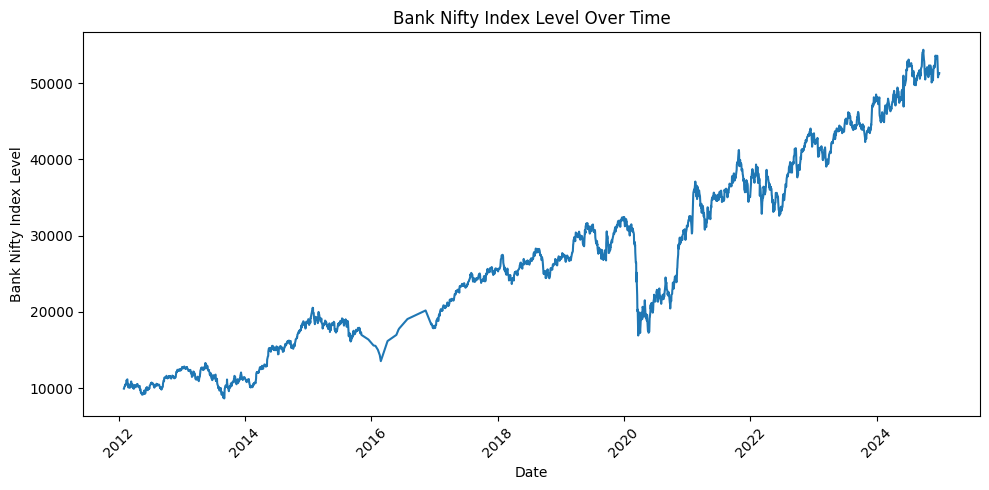

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["BN"])
plt.title("Bank Nifty Index Level Over Time")
plt.xlabel("Date")
plt.ylabel("Bank Nifty Index Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


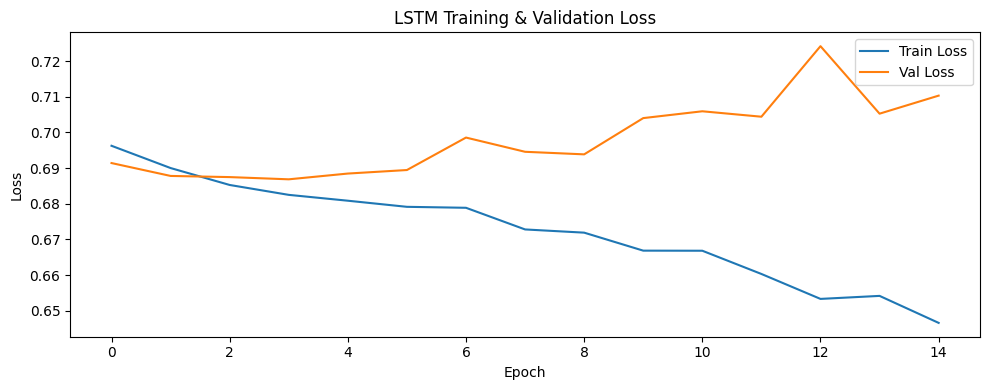

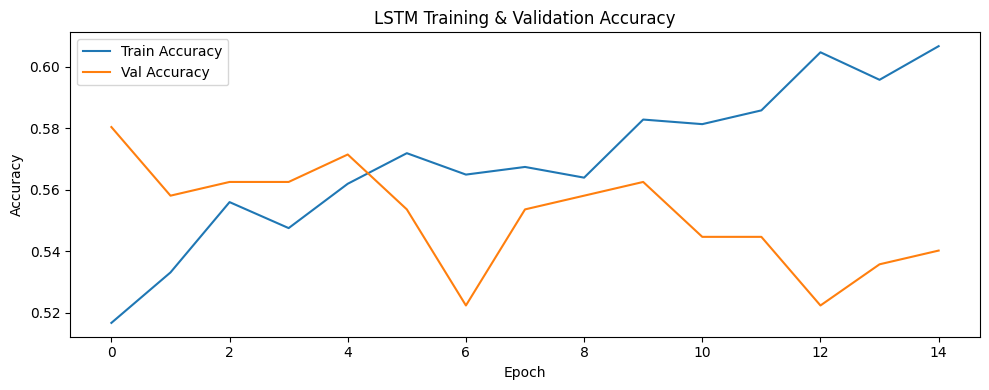

In [11]:
# Loss plot
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy plot
plt.figure(figsize=(10,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("LSTM Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
plt.savefig("bank_nifty_trend.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [14]:
plt.savefig(f"figure_{i}.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>